In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import matplotlib as mpl
import mplhep
import sys

sys.path.append("../../../analysisTools/")
import plotTools as ptools

In [2]:
# Initialize some dictionary that will later be used
signal_df = {} # yield
signal_match_df = {} # gen matched vtx

signal_reco_df = {} # yield only counting the events where gen ee are reconstructed
signal_match_reco_df = {} # gen matched vtx, out of the events where gen ee are reconstructed

for delta in ['0p1','0p2']:
    signal_df[delta] = {}
    signal_match_df[delta] = {}
    signal_reco_df[delta] = {}
    signal_match_reco_df[delta] = {}

In [3]:
sqrtBs = {'1': 0, '10': 0, '100': 0}

In [4]:
def plot_efficiency_signal_varying_M1(df_sig, dict_eff, cuts, cutNames, delta, ct, ylim = [1e-5,5e-2], ylabel='Efficiency', doLegend=True, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    m1s = sorted(list(set(df_sig[(df_sig.delta==delta)&(df_sig.ctau==ct)].m1)))
        
    for m1 in m1s:
        pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
        effs = [dict_eff[pt][cut] for cut in cuts]
        plt.plot(np.arange(len(cuts)), effs, label=r"$M_1 = {0}$ GeV".format(m1), color=f"C{m1s.index(m1)}")

    if doLog:
        plt.yscale('log')

    plt.ylabel(ylabel)
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    plt.ylim(ylim)
    
    if doLegend:
        plt.legend()
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

In [5]:
def plot_counts_signal_varying_M1(df_sig, dict_eff, cuts, cutNames, delta, ct, ylabel='Events', doLegend=True, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    m1s = sorted(list(set(df_sig[(df_sig.delta==delta)&(df_sig.ctau==ct)].m1)))
        
    for m1 in m1s:
        pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
        effs = [dict_eff[pt][cut] for cut in cuts]
        plt.plot(np.arange(len(cuts)), effs, label=r"$M_1 = {0}$ GeV".format(m1), color=f"C{m1s.index(m1)}")

    if doLog:
        plt.yscale('log')

    plt.ylabel(ylabel)
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    if doLegend:
        plt.legend()
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

## Ctau-1

### Import coffea files -- signal and background

In [6]:
prefix = './coffea/skimmed/'
suffix = '_SR_BDTv1_ctau-1_5to50_skimmed'

In [7]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [8]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

### Cutflow Dataframe -- signal

In [9]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

In [10]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [11]:
# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

In [12]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

In [13]:
deltas = sorted(list(set(si.delta)))

#### For signal events

In [14]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

In [15]:
sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_df.index = cut

In [16]:
sig_eff_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,0.033826,0.009426,0.007917,0.003161
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,0.014782,0.003136,0.002708,0.000839
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,0.014484,0.002886,0.002380,0.000796
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,0.036445,0.008902,0.007712,0.002719
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,0.020878,0.005298,0.004643,0.001971
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,0.030396,0.007135,0.006127,0.002177
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,0.023214,0.005053,0.004338,0.001427
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,0.016920,0.004024,0.003437,0.001397
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,0.018942,0.004017,0.003370,0.001130
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,0.014729,0.003148,0.002666,0.000949


In [17]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

In [18]:
sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [19]:
sig_cts_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,205.186408,57.180353,48.025582,19.171756
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,62382.758208,13235.666814,11429.745437,3540.924824
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,2748.241352,547.622429,451.519079,150.967962
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,6585.302053,1608.579945,1393.447034,491.364162
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,49723.242758,12618.624967,11057.113236,4694.611565
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,16108.593245,3781.029007,3246.954592,1153.924982
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,33794.913061,7356.157096,6314.429388,2076.834253
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,995.446867,236.713320,202.210754,82.163738
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,30374.505276,6441.605298,5403.497955,1811.504593
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,1394.264143,298.008932,252.364528,89.824578


In [20]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [21]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,1.0,0.443749,0.460946,0.985877
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1.0,0.300678,0.315971,0.965383
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,1.0,0.319274,0.330082,0.961586
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,1.0,0.369781,0.376774,0.961045
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,1.0,0.422382,0.422431,0.958257
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1.0,0.350106,0.355382,0.959658
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1.0,0.326664,0.325187,0.961204
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,1.0,0.389765,0.400093,0.965876
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1.0,0.336599,0.336555,0.966876
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,1.0,0.330039,0.341581,0.954939


#### For signal events having gen ee reconstructed (having reco e with dR < 0.1)

In [22]:
sig_columns_reco = list(cf_s_reco.keys())
sig_efficiency_reco = {c: [ cf_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}
sig_match_reco = {c: [ fr_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [23]:
sig_eff_reco_df = pd.DataFrame.from_dict(sig_efficiency_reco).transpose()
sig_eff_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_reco_df.index = cut

In [24]:
sig_eff_reco_df

,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-10p5_dMchi-1p0_ctau-1
Preselections,0.018895,0.005871,0.007196,0.017199,0.010975,0.014118,0.010520,0.008736,0.008445,0.007452,0.006857
0 < n(jet) < 3 & n(good vertex) > 0,0.006584,0.001707,0.001690,0.005296,0.003531,0.004071,0.002860,0.002567,0.002317,0.001927,0.001906
No b-tagged jets,0.005696,0.001491,0.001424,0.004640,0.003082,0.003541,0.002481,0.002233,0.001949,0.001659,0.001611
BDT Loose WP,0.003161,0.000827,0.000779,0.002679,0.001936,0.002149,0.001415,0.001392,0.001116,0.000935,0.000917


In [25]:
sig_counts_reco = {c: [ ct_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [26]:
sig_cts_reco_df = pd.DataFrame.from_dict(sig_counts_reco).transpose()
sig_cts_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_reco_df.index = cut

In [27]:
sig_cts_reco_df

,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-10p5_dMchi-1p0_ctau-1
Preselections,114.614464,24776.055248,1365.476804,3107.722465,26139.127171,7482.241053,15314.917103,513.957969,13541.062373,705.454678,16958.967758
0 < n(jet) < 3 & n(good vertex) > 0,39.938086,7205.591202,320.591914,956.846801,8409.758436,2157.411739,4163.532128,151.016756,3715.082204,182.397293,4714.580088
No b-tagged jets,34.551006,6293.661037,270.279248,838.460064,7341.025833,1876.583958,3612.288434,131.383074,3125.321970,157.021327,3984.140424
BDT Loose WP,19.171756,3488.456067,147.749317,484.124235,4611.485258,1138.873819,2060.037531,81.882995,1790.282869,88.548852,2266.933652


In [28]:
sig_match_reco_df = pd.DataFrame.from_dict(sig_match_reco).transpose()
sig_match_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_reco_df.index = cut

In [29]:
sig_match_reco_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,1.0,0.635326,0.640711,0.985877
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1.0,0.552303,0.573826,0.979903
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,1.0,0.545371,0.551423,0.982533
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,1.0,0.621648,0.626166,0.975418
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,1.0,0.633774,0.636269,0.975530
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1.0,0.613588,0.614899,0.972341
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1.0,0.577153,0.568439,0.969042
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,1.0,0.610943,0.615780,0.969188
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1.0,0.583631,0.581884,0.978337
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,1.0,0.539233,0.548989,0.968696


In [30]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,1.0,0.443749,0.460946,0.985877
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1.0,0.300678,0.315971,0.965383
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,1.0,0.319274,0.330082,0.961586
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,1.0,0.369781,0.376774,0.961045
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,1.0,0.422382,0.422431,0.958257
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1.0,0.350106,0.355382,0.959658
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1.0,0.326664,0.325187,0.961204
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,1.0,0.389765,0.400093,0.965876
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1.0,0.336599,0.336555,0.966876
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,1.0,0.330039,0.341581,0.954939


### Cutflow Dataframe -- background

In [31]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])

In [32]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [33]:
for b in bkg_histos.keys():
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

In [34]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            cts_dict[c] += cfd[k][c]

    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

In [35]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

In [36]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

In [37]:
bkg_columns = list(bkg_histos.keys())
bkg_columns.append('total')

tot_bkg_effs['total'] = bkg_summed_eff
tot_bkg_cts['total'] = bkg_summed_cts

In [38]:
bkg_efficiency = {c: [ tot_bkg_effs[samp][c] for samp in bkg_columns ] for c in cuts}
bkg_counts = {c: [ tot_bkg_cts[samp][c] for samp in bkg_columns ] for c in cuts}

In [39]:
bkg_eff_df = pd.DataFrame.from_dict(bkg_efficiency).transpose()
bkg_eff_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_eff_df.index = cut

In [40]:
bkg_eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,1.765167e-06,1.294682e-04,1.126054e-05,6.373026e-04,0.001933,2.309964e-03,0.006645,1.878092e-05
0 < n(jet) < 3 & n(good vertex) > 0,1.367991e-07,2.255081e-05,2.142595e-06,8.314492e-05,0.000268,3.211313e-04,0.000743,2.380365e-06
No b-tagged jets,9.141417e-08,1.426770e-05,1.956258e-06,6.151165e-05,0.000179,2.572087e-04,0.000608,1.906242e-06
BDT Loose WP,0.000000e+00,1.948715e-08,1.114804e-07,8.385791e-08,0.000000,7.243955e-07,0.000001,1.058992e-08


In [41]:
bkg_cts_df = pd.DataFrame.from_dict(bkg_counts).transpose()
bkg_cts_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_cts_df.index = cut

In [42]:
bkg_cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,38039.826987,5667.491120,14495.724273,4424.202428,52.996922,227212.601036,142220.153499,432112.996264
0 < n(jet) < 3 & n(good vertex) > 0,2948.058507,987.165470,2758.167766,577.198283,7.343808,31587.113375,15902.592237,54767.639446
No b-tagged jets,1970.000354,624.570742,2518.294909,427.018510,4.918245,25299.553501,13014.629253,43858.985515
BDT Loose WP,0.000000,0.853053,143.508952,0.582148,0.000000,71.252978,27.456575,243.653706


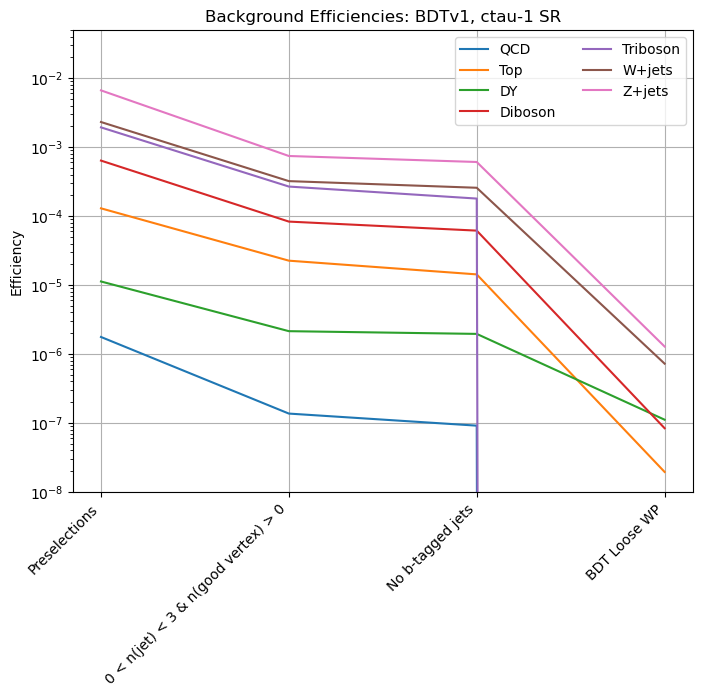

In [43]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title("Background Efficiencies: BDTv1, ctau-1 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
#plt.savefig(f"plots/cutflows/bkg_combined_efficiencies.png")

### Bkg Yield

In [44]:
sqrtB = np.sqrt(bkg_cts_df.iloc[-1].loc['total'])

print('Total background after last SR cut: {:.2f}'.format(bkg_cts_df['total'].iloc[-1]))
print('sqrt(B) = {:.2f}'.format(sqrtB))

Total background after last SR cut: 243.65
sqrt(B) = 15.61


In [45]:
sqrtBs['1'] = sqrtB

### Signal Yield and Vtx Gen Matching Fraction

In [46]:
s_df = sig_cts_df.iloc[-1]
s_match_df = sig_match_df.iloc[-1]

# when only looking at the events where gen ee are reconstructed (dR(gen,reco)<0.1)
s_reco_df = sig_cts_reco_df.iloc[-1]
s_match_reco_df = sig_match_reco_df.iloc[-1]

In [47]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in sig_columns:
    
    mchi = ptools.signalPoint(name)['mchi']
    dmchi = ptools.signalPoint(name)['dmchi']
    delta = ptools.signalPoint(name)['delta']

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '1'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-5p25_dMchi-0p5_ctau-1', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-1', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-1', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-1', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-1']


In [48]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['1']:
        signal_df[delta][ctau] = s_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_df[delta][ctau].rename(index = {signal_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_df[delta][ctau] = s_match_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_df[delta][ctau].rename(index = {signal_match_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [49]:
print('Signal yield for delta = 0.1, ctau = 10')
signal_df['0p1']['1'].transpose()

Signal yield for delta = 0.1, ctau = 10


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,2314.937104
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1811.504593
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,2076.834253
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1153.924982
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,491.364162
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,3540.924824


In [50]:
print('Vertex purity for delta = 0.1, ctau = 1')
signal_match_df['0p1']['1'].transpose()

Vertex purity for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,0.953923
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,0.966876
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,0.961204
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,0.959658
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,0.961045
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,0.965383


In [51]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['1']:
        signal_reco_df[delta][ctau] = s_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_reco_df[delta][ctau].rename(index = {signal_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_reco_df[delta][ctau] = s_match_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_reco_df[delta][ctau].rename(index = {signal_match_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [52]:
print('Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1')
signal_reco_df['0p1']['1'].transpose()

Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,2266.933652
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1790.282869
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,2060.037531
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1138.873819
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,484.124235
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,3488.456067


In [53]:
print('Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1')
signal_match_reco_df['0p1']['1'].transpose()

Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,0.974123
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,0.978337
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,0.969042
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,0.972341
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,0.975418
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,0.979903


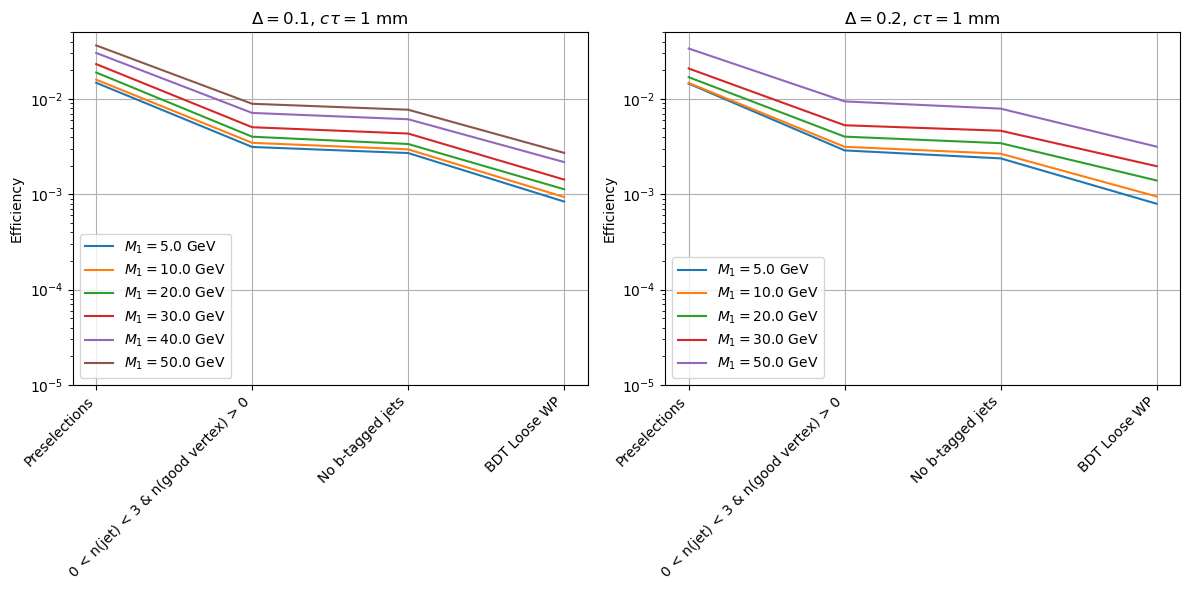

In [54]:
deltas = [0.1,0.2]

ct = 1

fig,axes = plt.subplots(1,len(deltas),figsize=(6*len(deltas),6))

for i, delta in enumerate(deltas):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

## Ctau-10

### Import coffea files -- signal and background

In [55]:
prefix = './coffea/skimmed/'
suffix = '_SR_BDTv1_ctau-10_5to50_skimmed'

In [56]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [57]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

### Cutflow Dataframe -- signal

In [58]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

In [59]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [60]:
# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

In [61]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

In [62]:
deltas = sorted(list(set(si.delta)))

#### For signal events

In [63]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

In [64]:
sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_df.index = cut

In [65]:
sig_eff_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,0.010930,0.001808,0.001501,0.000342
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,0.031125,0.007399,0.006364,0.002303
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,0.010659,0.001788,0.001528,0.000258
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,0.032445,0.006813,0.005813,0.001700
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,0.025603,0.005716,0.004744,0.001734
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,0.025736,0.005311,0.004518,0.001351
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,0.019309,0.003764,0.003227,0.001142
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,0.015844,0.003001,0.002565,0.000825
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,0.020128,0.004098,0.003541,0.001036
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,0.016286,0.003087,0.002710,0.000657


In [66]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

In [67]:
sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [68]:
sig_cts_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,211.621136,35.000147,29.056291,6.615410
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,18.964345,4.508315,3.877850,1.403043
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,6080.537001,1019.781283,871.560994,147.016441
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,625.950369,131.443263,112.141573,32.806534
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,49.031732,10.946414,9.085753,3.321626
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1560.736404,322.075962,273.988934,81.913546
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,15555.452101,3032.165629,2599.360072,920.072874
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,94.038554,17.809058,15.223959,4.896074
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,27263.499942,5550.591512,4796.622742,1403.131597
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,3043.716542,577.015788,506.474073,122.861554


In [69]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [70]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,1.0,0.196621,0.206964,0.888856
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,1.0,0.383492,0.390265,0.947565
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.0,0.160302,0.167314,0.919992
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,1.0,0.303958,0.299585,0.950519
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,1.0,0.364770,0.379017,0.935769
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1.0,0.285958,0.294511,0.938651
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,1.0,0.343078,0.347806,0.945628
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,1.0,0.287077,0.302153,0.923239
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1.0,0.280707,0.284856,0.949414
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,1.0,0.230717,0.228706,0.912463


#### For signal events having gen ee reconstructed (having reco e with dR < 0.1)

In [71]:
sig_columns_reco = list(cf_s_reco.keys())
sig_efficiency_reco = {c: [ cf_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}
sig_match_reco = {c: [ fr_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [72]:
sig_eff_reco_df = pd.DataFrame.from_dict(sig_efficiency_reco).transpose()
sig_eff_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_reco_df.index = cut

In [73]:
sig_eff_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,sig_2018_Mchi-10p5_dMchi-1p0_ctau-10
Preselections,0.002953,0.013324,0.002078,0.011383,0.010875,0.009198,0.007543,0.005962,0.006725,0.004959,0.004207,0.003264
0 < n(jet) < 3 & n(good vertex) > 0,0.000666,0.004200,0.000546,0.003331,0.003231,0.002540,0.001993,0.001498,0.001841,0.001295,0.000971,0.000911
No b-tagged jets,0.000569,0.003640,0.000476,0.002821,0.002754,0.002180,0.001724,0.001303,0.001576,0.001115,0.000788,0.000782
BDT Loose WP,0.000321,0.002242,0.000247,0.001645,0.001687,0.001306,0.001112,0.000785,0.001013,0.000625,0.000424,0.000420


In [74]:
sig_counts_reco = {c: [ ct_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [75]:
sig_cts_reco_df = pd.DataFrame.from_dict(sig_counts_reco).transpose()
sig_cts_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_reco_df.index = cut

In [76]:
sig_cts_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,sig_2018_Mchi-10p5_dMchi-1p0_ctau-10
Preselections,57.180228,8.118168,1185.424583,219.612491,20.826799,557.796672,6077.058542,35.387738,9108.794445,926.846220,39.578703,942.926775
0 < n(jet) < 3 & n(good vertex) > 0,12.892489,2.559109,311.671045,64.255611,6.188161,154.049592,1605.364851,8.893170,2494.018958,241.976376,9.131426,263.128074
No b-tagged jets,11.023025,2.217613,271.667833,54.421464,5.273268,132.184152,1389.012688,7.731100,2134.139346,208.346904,7.416005,225.857295
BDT Loose WP,6.214331,1.366196,141.125490,31.739402,3.229907,79.198305,896.074113,4.656926,1371.613618,116.781089,3.986242,121.245697


In [77]:
sig_match_reco_df = pd.DataFrame.from_dict(sig_match_reco).transpose()
sig_match_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_reco_df.index = cut

In [78]:
sig_match_reco_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,1.0,0.533780,0.545549,0.946223
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,1.0,0.675588,0.682441,0.973121
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.0,0.524504,0.536776,0.958395
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,1.0,0.621786,0.617330,0.982477
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,1.0,0.645253,0.653040,0.962342
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1.0,0.597862,0.610456,0.970832
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,1.0,0.647995,0.650874,0.970954
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,1.0,0.574888,0.594996,0.970651
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1.0,0.624731,0.640234,0.971231
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,1.0,0.550167,0.555965,0.959972


In [79]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,1.0,0.196621,0.206964,0.888856
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,1.0,0.383492,0.390265,0.947565
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.0,0.160302,0.167314,0.919992
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,1.0,0.303958,0.299585,0.950519
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,1.0,0.364770,0.379017,0.935769
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1.0,0.285958,0.294511,0.938651
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,1.0,0.343078,0.347806,0.945628
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,1.0,0.287077,0.302153,0.923239
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1.0,0.280707,0.284856,0.949414
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,1.0,0.230717,0.228706,0.912463


### Cutflow Dataframe -- background

In [80]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])

In [81]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [82]:
for b in bkg_histos.keys():
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

In [83]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            cts_dict[c] += cfd[k][c]

    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

In [84]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

In [85]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

In [86]:
bkg_columns = list(bkg_histos.keys())
bkg_columns.append('total')

tot_bkg_effs['total'] = bkg_summed_eff
tot_bkg_cts['total'] = bkg_summed_cts

In [87]:
bkg_efficiency = {c: [ tot_bkg_effs[samp][c] for samp in bkg_columns ] for c in cuts}
bkg_counts = {c: [ tot_bkg_cts[samp][c] for samp in bkg_columns ] for c in cuts}

In [88]:
bkg_eff_df = pd.DataFrame.from_dict(bkg_efficiency).transpose()
bkg_eff_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_eff_df.index = cut

In [89]:
bkg_eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,1.765167e-06,1.294682e-04,0.000011,6.373026e-04,0.001933,2.309964e-03,6.645339e-03,1.878092e-05
0 < n(jet) < 3 & n(good vertex) > 0,1.367991e-07,2.255081e-05,0.000002,8.314492e-05,0.000268,3.211313e-04,7.430600e-04,2.380365e-06
No b-tagged jets,9.141417e-08,1.426770e-05,0.000002,6.151165e-05,0.000179,2.572087e-04,6.081179e-04,1.906242e-06
BDT Loose WP,0.000000e+00,3.720636e-10,0.000000,4.192895e-08,0.000000,4.176507e-07,6.028946e-07,2.359656e-09


In [90]:
bkg_cts_df = pd.DataFrame.from_dict(bkg_counts).transpose()
bkg_cts_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_cts_df.index = cut

In [91]:
bkg_cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,38039.826987,5667.491120,14495.724273,4424.202428,52.996922,227212.601036,142220.153499,432112.996264
0 < n(jet) < 3 & n(good vertex) > 0,2948.058507,987.165470,2758.167766,577.198283,7.343808,31587.113375,15902.592237,54767.639446
No b-tagged jets,1970.000354,624.570742,2518.294909,427.018510,4.918245,25299.553501,13014.629253,43858.985515
BDT Loose WP,0.000000,0.016287,0.000000,0.291074,0.000000,41.080956,12.902844,54.291160


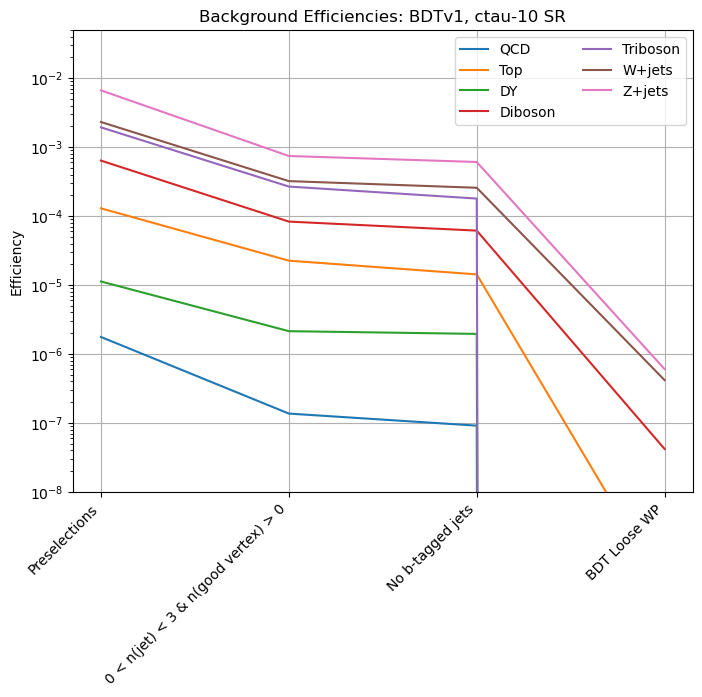

In [92]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title("Background Efficiencies: BDTv1, ctau-10 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
#plt.savefig(f"plots/cutflows/bkg_combined_efficiencies.png")

### Bkg Yield

In [93]:
sqrtB = np.sqrt(bkg_cts_df.iloc[-1].loc['total'])

print('Total background after last SR cut: {:.2f}'.format(bkg_cts_df['total'].iloc[-1]))
print('sqrt(B) = {:.2f}'.format(sqrtB))

Total background after last SR cut: 54.29
sqrt(B) = 7.37


In [94]:
sqrtBs['10'] = sqrtB

### Signal Yield and Vtx Gen Matching Fraction

In [95]:
s_df = sig_cts_df.iloc[-1]
s_match_df = sig_match_df.iloc[-1]

# when only looking at the events where gen ee are reconstructed (dR(gen,reco)<0.1)
s_reco_df = sig_cts_reco_df.iloc[-1]
s_match_reco_df = sig_match_reco_df.iloc[-1]

In [96]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in sig_columns:
    
    mchi = ptools.signalPoint(name)['mchi']
    dmchi = ptools.signalPoint(name)['dmchi']
    delta = ptools.signalPoint(name)['delta']

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '10'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-5p25_dMchi-0p5_ctau-10', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-10', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-10']


In [97]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['10']:
        signal_df[delta][ctau] = s_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_df[delta][ctau].rename(index = {signal_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_df[delta][ctau] = s_match_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_df[delta][ctau].rename(index = {signal_match_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [98]:
print('Signal yield for delta = 0.1, ctau = 10')
signal_df['0p1']['10'].transpose()

Signal yield for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,125.289529
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,122.861554
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1403.131597
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,81.913546
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,32.806534
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,147.016441


In [99]:
print('Vertex purity for delta = 0.1, ctau = 10')
signal_match_df['0p1']['10'].transpose()

Vertex purity for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,0.931844
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,0.912463
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,0.949414
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,0.938651
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,0.950519
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,0.919992


In [100]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['10']:
        signal_reco_df[delta][ctau] = s_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_reco_df[delta][ctau].rename(index = {signal_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_reco_df[delta][ctau] = s_match_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_reco_df[delta][ctau].rename(index = {signal_match_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [101]:
print('Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10')
signal_reco_df['0p1']['10'].transpose()

Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,121.245697
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,116.781089
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1371.613618
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,79.198305
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,31.739402
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,141.125490


In [102]:
print('Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10')
signal_match_reco_df['0p1']['10'].transpose()

Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,0.962924
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,0.959972
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,0.971231
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,0.970832
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,0.982477
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,0.958395


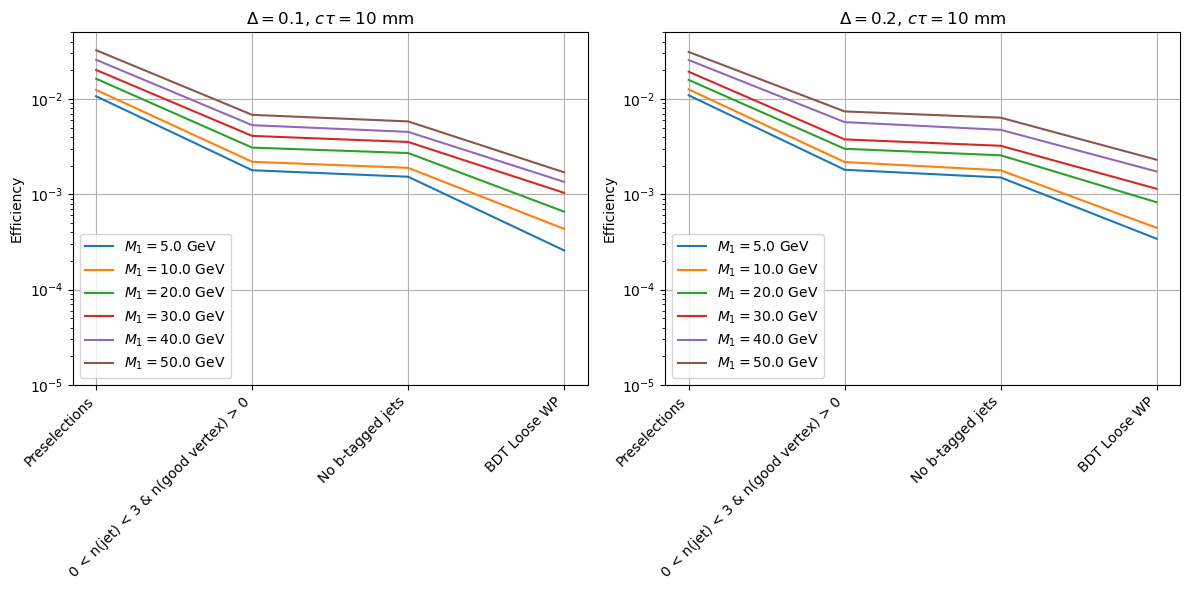

In [103]:
deltas = [0.1,0.2]

ct = 10

fig,axes = plt.subplots(1,len(deltas),figsize=(6*len(deltas),6))

for i, delta in enumerate(deltas):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

## Ctau-100

### Import coffea files -- signal and background

In [104]:
prefix = './coffea/skimmed/'
suffix = '_SR_BDTv1_ctau-100_5to50_skimmed'

In [105]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [106]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

### Cutflow Dataframe -- signal

In [107]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

In [108]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [109]:
# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

In [110]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

In [111]:
deltas = sorted(list(set(si.delta)))

#### For signal events

In [112]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

In [113]:
sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_df.index = cut

In [114]:
sig_eff_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,0.007414,0.001127,0.000981,0.000075
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,0.007304,0.001070,0.000907,0.000048
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,0.022439,0.003937,0.003324,0.000661
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.022522,0.003791,0.003235,0.000521
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,0.017759,0.002969,0.002463,0.000434
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,0.013585,0.002093,0.001752,0.000277
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,0.017686,0.002805,0.002384,0.000364
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,0.013533,0.002087,0.001809,0.000210
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,0.010335,0.001509,0.001295,0.000205
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,0.010649,0.001609,0.001411,0.000134


In [115]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

In [116]:
sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [117]:
sig_cts_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,14.287467,2.172012,1.889810,0.144363
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,443.518062,64.955403,55.049808,2.943662
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.367489,0.239920,0.202577,0.040297
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,43.757279,7.364887,6.285853,1.011624
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,3.387082,0.566187,0.469794,0.082856
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1302.773429,200.743999,168.009549,26.569218
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,108.959604,17.279938,14.685996,2.244593
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,24702.134075,3809.828136,3301.810971,383.593635
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,6.142378,0.896654,0.769692,0.122050
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,200.845692,30.341982,26.620781,2.525776


In [118]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [119]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,1.0,0.066503,0.069479,0.863754
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.0,0.048495,0.048947,0.802866
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.0,0.187506,0.196018,0.912570
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.0,0.149223,0.152865,0.894142
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,1.0,0.169019,0.177705,0.914673
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1.0,0.144585,0.146420,0.879646
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.0,0.137197,0.141424,0.890993
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,1.0,0.103473,0.102710,0.842520
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,1.0,0.132847,0.134296,0.822702
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.0,0.080807,0.080151,0.825331


#### For signal events having gen ee reconstructed (having reco e with dR < 0.1)

In [120]:
sig_columns_reco = list(cf_s_reco.keys())
sig_efficiency_reco = {c: [ cf_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}
sig_match_reco = {c: [ fr_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [121]:
sig_eff_reco_df = pd.DataFrame.from_dict(sig_efficiency_reco).transpose()
sig_eff_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_reco_df.index = cut

In [122]:
sig_eff_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,sig_2018_Mchi-11p0_dMchi-2p0_ctau-100,sig_2018_Mchi-10p5_dMchi-1p0_ctau-100
Preselections,0.000429,0.000302,0.004794,0.003601,0.003346,0.002362,0.002573,0.001738,0.001522,0.001148,0.000805,0.000557
0 < n(jet) < 3 & n(good vertex) > 0,0.000140,0.000096,0.001300,0.000938,0.000805,0.000526,0.000632,0.000393,0.000338,0.000269,0.000160,0.000145
No b-tagged jets,0.000123,0.000082,0.001114,0.000802,0.000694,0.000446,0.000549,0.000338,0.000301,0.000239,0.000136,0.000125
BDT Loose WP,0.000065,0.000043,0.000629,0.000484,0.000408,0.000262,0.000333,0.000186,0.000172,0.000114,0.000071,0.000068


In [123]:
sig_counts_reco = {c: [ ct_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [124]:
sig_cts_reco_df = pd.DataFrame.from_dict(sig_counts_reco).transpose()
sig_cts_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_reco_df.index = cut

In [125]:
sig_cts_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,sig_2018_Mchi-11p0_dMchi-2p0_ctau-100,sig_2018_Mchi-10p5_dMchi-1p0_ctau-100
Preselections,0.827147,18.364086,0.292147,6.996573,0.638121,226.543294,15.852945,3172.494297,0.904543,21.643236,0.766447,16.546979
0 < n(jet) < 3 & n(good vertex) > 0,0.269058,5.844165,0.079208,1.823054,0.153527,50.409151,3.894721,717.339756,0.200838,5.075234,0.152475,4.308990
No b-tagged jets,0.236236,4.974496,0.067871,1.558310,0.132334,42.787908,3.383979,616.112208,0.179176,4.512204,0.129125,3.715923
BDT Loose WP,0.124694,2.611906,0.038340,0.941194,0.077720,25.092022,2.048884,339.181618,0.102379,2.158215,0.067307,2.016509


In [126]:
sig_match_reco_df = pd.DataFrame.from_dict(sig_match_reco).transpose()
sig_match_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_reco_df.index = cut

In [127]:
sig_match_reco_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,1.0,0.536858,0.555805,1.000000
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.0,0.538997,0.541671,0.904843
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.0,0.567949,0.585065,0.959141
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.0,0.602840,0.616621,0.961051
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,1.0,0.623318,0.630866,0.975124
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1.0,0.575781,0.574926,0.931432
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.0,0.608711,0.613760,0.976101
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,1.0,0.549551,0.550432,0.952839
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,1.0,0.593103,0.576899,0.980776
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.0,0.483099,0.472867,0.965891


In [128]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,1.0,0.066503,0.069479,0.863754
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.0,0.048495,0.048947,0.802866
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.0,0.187506,0.196018,0.912570
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.0,0.149223,0.152865,0.894142
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,1.0,0.169019,0.177705,0.914673
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1.0,0.144585,0.146420,0.879646
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.0,0.137197,0.141424,0.890993
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,1.0,0.103473,0.102710,0.842520
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,1.0,0.132847,0.134296,0.822702
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.0,0.080807,0.080151,0.825331


### Cutflow Dataframe -- background

In [129]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])

In [130]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [131]:
for b in bkg_histos.keys():
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

In [132]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            cts_dict[c] += cfd[k][c]

    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

In [133]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

In [134]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

In [135]:
bkg_columns = list(bkg_histos.keys())
bkg_columns.append('total')

tot_bkg_effs['total'] = bkg_summed_eff
tot_bkg_cts['total'] = bkg_summed_cts

In [136]:
bkg_efficiency = {c: [ tot_bkg_effs[samp][c] for samp in bkg_columns ] for c in cuts}
bkg_counts = {c: [ tot_bkg_cts[samp][c] for samp in bkg_columns ] for c in cuts}

In [137]:
bkg_eff_df = pd.DataFrame.from_dict(bkg_efficiency).transpose()
bkg_eff_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_eff_df.index = cut

In [138]:
bkg_eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,1.765167e-06,1.294682e-04,0.000011,6.373026e-04,0.001933,2.309964e-03,6.645339e-03,1.878092e-05
0 < n(jet) < 3 & n(good vertex) > 0,1.367991e-07,2.255081e-05,0.000002,8.314492e-05,0.000268,3.211313e-04,7.430600e-04,2.380365e-06
No b-tagged jets,9.141417e-08,1.426770e-05,0.000002,6.151165e-05,0.000179,2.572087e-04,6.081179e-04,1.906242e-06
BDT Loose WP,0.000000e+00,2.066750e-09,0.000000,8.385791e-08,0.000000,4.113957e-07,6.036490e-07,2.349492e-09


In [139]:
bkg_cts_df = pd.DataFrame.from_dict(bkg_counts).transpose()
bkg_cts_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_cts_df.index = cut

In [140]:
bkg_cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,38039.826987,5667.491120,14495.724273,4424.202428,52.996922,227212.601036,142220.153499,432112.996264
0 < n(jet) < 3 & n(good vertex) > 0,2948.058507,987.165470,2758.167766,577.198283,7.343808,31587.113375,15902.592237,54767.639446
No b-tagged jets,1970.000354,624.570742,2518.294909,427.018510,4.918245,25299.553501,13014.629253,43858.985515
BDT Loose WP,0.000000,0.090472,0.000000,0.582148,0.000000,40.465696,12.918988,54.057304


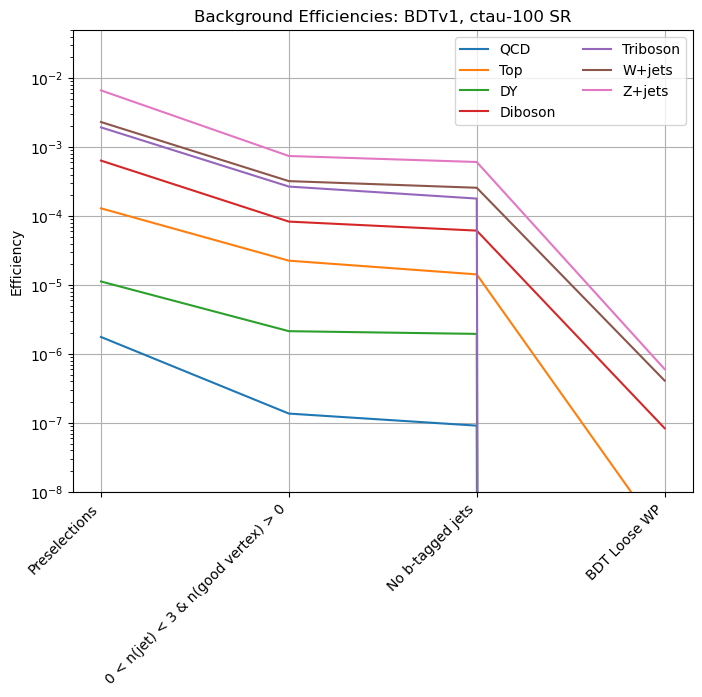

In [141]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title("Background Efficiencies: BDTv1, ctau-100 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
#plt.savefig(f"plots/cutflows/bkg_combined_efficiencies.png")

### Bkg Yield

In [142]:
sqrtB = np.sqrt(bkg_cts_df.iloc[-1].loc['total'])

print('Total background after last SR cut: {:.2f}'.format(bkg_cts_df['total'].iloc[-1]))
print('sqrt(B) = {:.2f}'.format(sqrtB))

Total background after last SR cut: 54.06
sqrt(B) = 7.35


In [143]:
sqrtBs['100'] = sqrtB

### Signal Yield and Vtx Gen Matching Fraction

In [144]:
s_df = sig_cts_df.iloc[-1]
s_match_df = sig_match_df.iloc[-1]

# when only looking at the events where gen ee are reconstructed (dR(gen,reco)<0.1)
s_reco_df = sig_cts_reco_df.iloc[-1]
s_match_reco_df = sig_match_reco_df.iloc[-1]

In [145]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in sig_columns:
    
    mchi = ptools.signalPoint(name)['mchi']
    dmchi = ptools.signalPoint(name)['dmchi']
    delta = ptools.signalPoint(name)['delta']

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '100'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-5p25_dMchi-0p5_ctau-100', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-100', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-100', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-100']


In [146]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['100']:
        signal_df[delta][ctau] = s_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_df[delta][ctau].rename(index = {signal_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_df[delta][ctau] = s_match_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_df[delta][ctau].rename(index = {signal_match_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [147]:
print('Signal yield for delta = 0.1, ctau = 100')
signal_df['0p1']['100'].transpose()

Signal yield for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,2.510666
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,2.525776
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,383.593635
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,2.244593
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.011624
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,2.943662


In [148]:
print('Vertex purity for delta = 0.1, ctau = 100')
signal_match_df['0p1']['100'].transpose()

Vertex purity for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,0.763850
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,0.825331
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,0.842520
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,0.890993
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.894142
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,0.802866


In [149]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['100']:
        signal_reco_df[delta][ctau] = s_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_reco_df[delta][ctau].rename(index = {signal_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_reco_df[delta][ctau] = s_match_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_reco_df[delta][ctau].rename(index = {signal_match_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [150]:
print('Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100')
signal_reco_df['0p1']['100'].transpose()

Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,2.016509
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,2.158215
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,339.181618
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,2.048884
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.941194
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,2.611906


In [151]:
print('Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100')
signal_match_reco_df['0p1']['100'].transpose()

Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,0.951035
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,0.965891
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,0.952839
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,0.976101
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.961051
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,0.904843


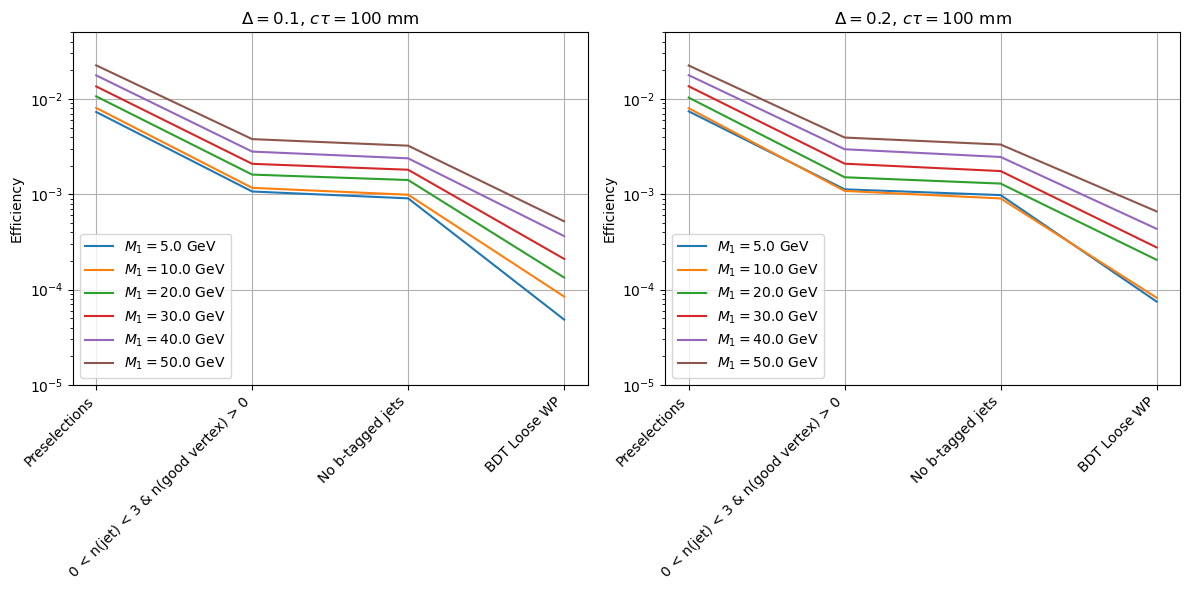

In [152]:
deltas = [0.1,0.2]

ct = 100

fig,axes = plt.subplots(1,len(deltas),figsize=(6*len(deltas),6))

for i, delta in enumerate(deltas):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

## Signal Yield for all ctaus

In [153]:
ctaus = ['1','10','100']

In [154]:
delta = '0p1'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_df[delta][ctau].columns]
    signal_df[delta][ctau].columns = m1s

    signal_df[delta][ctau] = signal_df[delta][ctau].sort_index(axis=1)

frames = [signal_df[delta]['1'], signal_df[delta]['10'], signal_df[delta]['100']]
delta_0p1_df = pd.concat(frames)

In [155]:
print('delta = 0p1, signal yield after last cut in SR')
delta_0p1_df

delta = 0p1, signal yield after last cut in SR


,5,10,20,30,40,50
1mm,3540.924824,2314.937104,1811.504593,2076.834253,1153.924982,491.364162
10mm,147.016441,125.289529,122.861554,1403.131597,81.913546,32.806534
100mm,2.943662,2.510666,2.525776,383.593635,2.244593,1.011624


In [156]:
for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_reco_df[delta][ctau].columns]
    signal_reco_df[delta][ctau].columns = m1s

    signal_reco_df[delta][ctau] = signal_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_reco_df[delta]['1'], signal_reco_df[delta]['10'], signal_reco_df[delta]['100']]
delta_0p1_reco_df = pd.concat(frames)

In [157]:
print('delta = 0p1, signal yield for events where gen ee are reconstructed, after last cut in SR')
delta_0p1_reco_df

delta = 0p1, signal yield for events where gen ee are reconstructed, after last cut in SR


,5,10,20,30,40,50
1mm,3488.456067,2266.933652,1790.282869,2060.037531,1138.873819,484.124235
10mm,141.125490,121.245697,116.781089,1371.613618,79.198305,31.739402
100mm,2.611906,2.016509,2.158215,339.181618,2.048884,0.941194


In [158]:
# take care of missing sample with dummy column
signal_df['0p2']['1'].insert(3, 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-1', 0)
signal_reco_df['0p2']['1'].insert(3, 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-1', 0)

signal_match_df['0p2']['1'].insert(3, 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-1', 0)
signal_match_reco_df['0p2']['1'].insert(3, 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-1', 0)

signal_match_reco_df['0p2']['1']

,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,sig_2018_Mchi-44p0_dMchi-8p0_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1
1mm,0.968696,0.969188,0.97553,0,0.982533,0.985877


In [159]:
delta = '0p2'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_df[delta][ctau].columns]
    signal_df[delta][ctau].columns = m1s

    signal_df[delta][ctau] = signal_df[delta][ctau].sort_index(axis=1)

frames = [signal_df[delta]['1'], signal_df[delta]['10'], signal_df[delta]['100']]
delta_0p2_df = pd.concat(frames)

In [160]:
print('delta = 0p2, signal yield after last cut in SR')
delta_0p2_df

delta = 0p2, signal yield after last cut in SR


,5,10,20,30,40,50
1mm,150.967962,89.824578,82.163738,4694.611565,0.000000,19.171756
10mm,6.615410,4.188295,4.896074,920.072874,3.321626,1.403043
100mm,0.144363,0.078299,0.122050,26.569218,0.082856,0.040297


In [161]:
delta = '0p2'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_reco_df[delta][ctau].columns]
    signal_reco_df[delta][ctau].columns = m1s

    signal_reco_df[delta][ctau] = signal_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_reco_df[delta]['1'], signal_reco_df[delta]['10'], signal_reco_df[delta]['100']]
delta_0p2_reco_df = pd.concat(frames)

In [162]:
print('delta = 0p2, signal yield for events where gen ee are reconstructed, after last cut in SR')
delta_0p2_reco_df

delta = 0p2, signal yield for events where gen ee are reconstructed, after last cut in SR


,5,10,20,30,40,50
1mm,147.749317,88.548852,81.882995,4611.485258,0.000000,19.171756
10mm,6.214331,3.986242,4.656926,896.074113,3.229907,1.366196
100mm,0.124694,0.067307,0.102379,25.092022,0.077720,0.038340


## Display S/B

In [163]:
pd.set_option("display.precision", 3)

In [164]:
delta = '0p1'

frames = [delta_0p1_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p1_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p1_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p1_SoverB_df = pd.concat(frames)

delta_0p1_SoverB_df = delta_0p1_SoverB_df.sort_index(axis=1)

In [165]:
print('delta = 0.1, S/sqrt(B)')

delta_0p1_SoverB_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_SoverB_df

delta = 0.1, S/sqrt(B)


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,226.846,148.304,116.052,133.050,73.925,31.479
10mm,19.953,17.004,16.674,190.429,11.117,4.452
100mm,0.400,0.341,0.344,52.173,0.305,0.138


In [166]:
delta = '0p1'

frames = [delta_0p1_reco_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p1_reco_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p1_reco_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p1_SoverB_reco_df = pd.concat(frames)

delta_0p1_SoverB_reco_df = delta_0p1_SoverB_reco_df.sort_index(axis=1)

print('delta = 0.1, S/sqrt(B), only counting the signal events where gen ee are reconstructed')

delta_0p1_SoverB_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_SoverB_reco_df

delta = 0.1, S/sqrt(B), only counting the signal events where gen ee are reconstructed


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,223.484,145.229,114.693,131.974,72.961,31.015
10mm,19.153,16.455,15.849,186.152,10.749,4.308
100mm,0.355,0.274,0.294,46.132,0.279,0.128


In [167]:
delta = '0p2'

frames = [delta_0p2_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p2_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p2_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p2_SoverB_df = pd.concat(frames)

delta_0p2_SoverB_df = delta_0p2_SoverB_df.sort_index(axis=1)

In [168]:
print('delta = 0.2, S/sqrt(B)')

delta_0p2_SoverB_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_SoverB_df

delta = 0.2, S/sqrt(B)


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,9.672,5.755,5.264,300.755,0.000,1.228
10mm,0.898,0.568,0.664,124.870,0.451,0.190
100mm,0.020,0.011,0.017,3.614,0.011,0.005


In [169]:
delta = '0p2'

frames = [delta_0p2_reco_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p2_reco_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p2_reco_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p2_SoverB_reco_df = pd.concat(frames)

delta_0p2_SoverB_reco_df = delta_0p2_SoverB_reco_df.sort_index(axis=1)

print('delta = 0.2, S/sqrt(B), only counting the signal events where gen ee are reconstructed')

delta_0p2_SoverB_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_SoverB_reco_df

delta = 0.2, S/sqrt(B), only counting the signal events where gen ee are reconstructed


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,9.465,5.673,5.246,295.430,0.000,1.228
10mm,0.843,0.541,0.632,121.613,0.438,0.185
100mm,0.017,0.009,0.014,3.413,0.011,0.005


In [170]:
ctaus = [1,10,100]

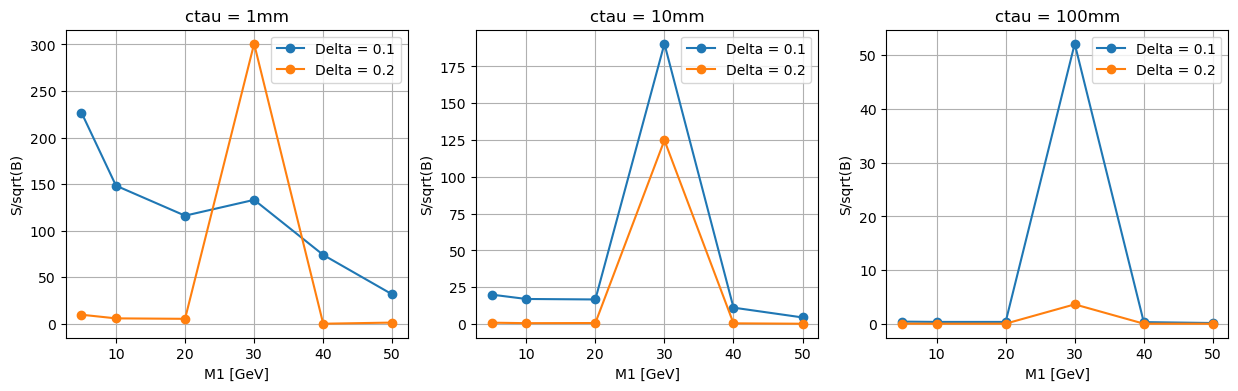

In [171]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ctau in enumerate(ctaus):
    ctau = int(ctau)
    
    y_arr_1 = delta_0p1_SoverB_df.iloc[idx].to_list()
    y_arr_2 = delta_0p2_SoverB_df.iloc[idx].to_list()

    x_arr = sorted(m1s)
    
    axes[idx].plot(x_arr, y_arr_1, '-o', label=f'Delta = 0.1')
    axes[idx].plot(x_arr, y_arr_2, '-o', label=f'Delta = 0.2')

    axes[idx].legend()
    
    axes[idx].set_xlabel('M1 [GeV]')
    axes[idx].set_ylabel('S/sqrt(B)')
    
    axes[idx].grid()
    
    axes[idx].set_title(f'ctau = {ctau}mm')

## Vtx purity (fraction of events whose selected vertex is gen matched) for all ctaus

In [172]:
ctaus = ['1','10','100']

In [173]:
delta = '0p1'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_df[delta][ctau].columns]
    signal_match_df[delta][ctau].columns = m1s

    signal_match_df[delta][ctau] = signal_match_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_df[delta]['1'], signal_match_df[delta]['10'], signal_match_df[delta]['100']]
delta_0p1_match_df = pd.concat(frames)

In [174]:
print('BDTv1 SR')
print('delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]')

delta_0p1_match_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_match_df

BDTv1 SR
delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.965,0.954,0.967,0.961,0.960,0.961
10mm,0.920,0.932,0.912,0.949,0.939,0.951
100mm,0.803,0.764,0.825,0.843,0.891,0.894


In [175]:
for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_reco_df[delta][ctau].columns]
    signal_match_reco_df[delta][ctau].columns = m1s

    signal_match_reco_df[delta][ctau] = signal_match_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_reco_df[delta]['1'], signal_match_reco_df[delta]['10'], signal_match_reco_df[delta]['100']]
delta_0p1_match_reco_df = pd.concat(frames)

In [176]:
print('BDTv1 SR')
print('delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]')
delta_0p1_match_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_match_reco_df

BDTv1 SR
delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.980,0.974,0.978,0.969,0.972,0.975
10mm,0.958,0.963,0.960,0.971,0.971,0.982
100mm,0.905,0.951,0.966,0.953,0.976,0.961


In [177]:
delta = '0p2'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_df[delta][ctau].columns]
    signal_match_df[delta][ctau].columns = m1s

    signal_match_df[delta][ctau] = signal_match_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_df[delta]['1'], signal_match_df[delta]['10'], signal_match_df[delta]['100']]
delta_0p2_match_df = pd.concat(frames)

In [178]:
print('BDTv1 SR')
print('delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]')

delta_0p2_match_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_match_df

BDTv1 SR
delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.962,0.955,0.966,0.958,0.000,0.986
10mm,0.889,0.928,0.923,0.946,0.936,0.948
100mm,0.864,0.842,0.823,0.880,0.915,0.913


In [179]:
for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_reco_df[delta][ctau].columns]
    signal_match_reco_df[delta][ctau].columns = m1s

    signal_match_reco_df[delta][ctau] = signal_match_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_reco_df[delta]['1'], signal_match_reco_df[delta]['10'], signal_match_reco_df[delta]['100']]
delta_0p2_match_reco_df = pd.concat(frames)

In [180]:
print('BDTv1 SR')
print('delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]')
delta_0p2_match_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_match_reco_df

BDTv1 SR
delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.983,0.969,0.969,0.976,0.000,0.986
10mm,0.946,0.975,0.971,0.971,0.962,0.973
100mm,1.000,0.980,0.981,0.931,0.975,0.959


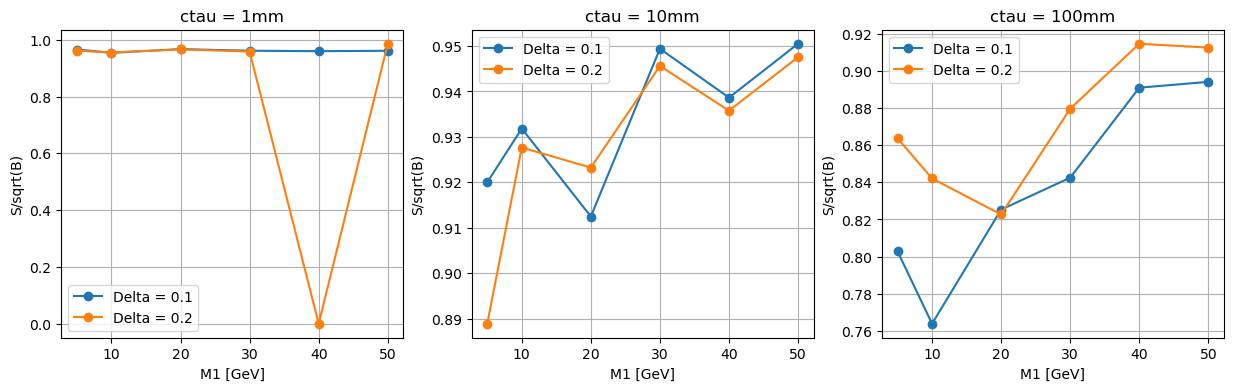

In [181]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ctau in enumerate(ctaus):
    ctau = int(ctau)
    
    y_arr_1 = delta_0p1_match_df.iloc[idx].to_list()
    y_arr_2 = delta_0p2_match_df.iloc[idx].to_list()

    x_arr = sorted(m1s)
    
    axes[idx].plot(x_arr, y_arr_1, '-o', label=f'Delta = 0.1')
    axes[idx].plot(x_arr, y_arr_2, '-o', label=f'Delta = 0.2')

    axes[idx].legend()
    
    axes[idx].set_xlabel('M1 [GeV]')
    axes[idx].set_ylabel('S/sqrt(B)')
    
    axes[idx].grid()
    
    axes[idx].set_title(f'ctau = {ctau}mm')

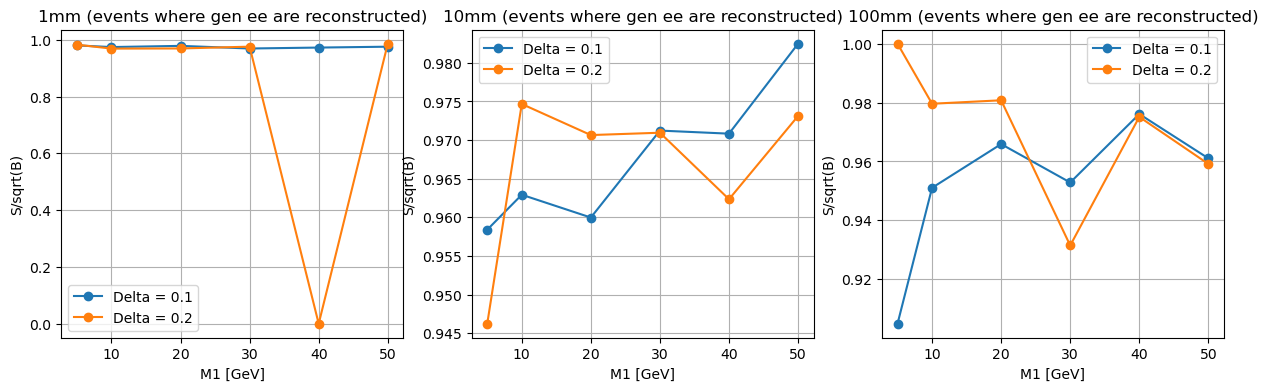

In [182]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ctau in enumerate(ctaus):
    ctau = int(ctau)
    
    y_arr_1 = delta_0p1_match_reco_df.iloc[idx].to_list()
    y_arr_2 = delta_0p2_match_reco_df.iloc[idx].to_list()

    x_arr = sorted(m1s)
    
    axes[idx].plot(x_arr, y_arr_1, '-o', label=f'Delta = 0.1')
    axes[idx].plot(x_arr, y_arr_2, '-o', label=f'Delta = 0.2')

    axes[idx].legend()
    
    axes[idx].set_xlabel('M1 [GeV]')
    axes[idx].set_ylabel('S/sqrt(B)')
    
    axes[idx].grid()
    
    axes[idx].set_title(f'{ctau}mm (events where gen ee are reconstructed)')

In [183]:
# export
delta_0p1_SoverB_df.to_csv('../BDTv1-based-SR_SoverB_delta_0p1.csv')
delta_0p2_SoverB_df.to_csv('../BDTv1-based-SR_SoverB_delta_0p2.csv') 

# export
delta_0p1_SoverB_reco_df.to_csv('../BDTv1-based-SR_SoverB_delta_0p1_hasGenEEreconstructed.csv')
delta_0p2_SoverB_reco_df.to_csv('../BDTv1-based-SR_SoverB_delta_0p2_hasGenEEreconstructed.csv') 

In [184]:
# export
delta_0p1_match_df.to_csv('../BDTv1-based-SR_Purity_delta_0p1.csv') 
delta_0p2_match_df.to_csv('../BDTv1-based-SR_Purity_delta_0p2.csv') 

delta_0p1_match_reco_df.to_csv('../BDTv1-based-SR_Purity_delta_0p1_hasGenEEreconstructed.csv') 
delta_0p2_match_reco_df.to_csv('../BDTv1-based-SR_Purity_delta_0p2_hasGenEEreconstructed.csv') 

In [185]:
bYields = {}

for bkg in sqrtBs.keys():
    bYields[bkg] = sqrtBs[bkg]**2

pd.DataFrame.from_dict(bYields, orient='index')

,0
1,243.654
10,54.291
100,54.057
